## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)
- [Resources](#resources)



<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Finding out the possible combinations
df.groupby("landing_page")["group"].value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [7]:
# new_page and control + old_page and treatment = 1928 + 1965 = 3893
df.query('landing_page == "new_page" and group == "control" or landing_page == "old_page" and group == "treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().any(axis=1).sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('landing_page == "new_page" and group == "treatment" or landing_page == "old_page" and group == "control"')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<h3>Answer:</h3>
<ul>
- The propability of receiving the new page is about 50%. Meaning that the chance of either landing on the new page or the old one are about equal.
<br><br>
- Based on that, we can fairly assume that the probability of conversion when landing in the new page is greater than that of the old one and thus, <b>statistically</b> speaking, we conclude that the new treatment page leads to more conversions.
<br><br>
- However, it's noticable that this difference in probability is in fact not that large and can be negligible depending on the circumstances. The improvement in percentage was actually less than 1.2% and may not be of any actual <b>practical</b> use in real life. </ul>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<b>
The Null and Alternative Hypotheses are:
<br><br>
<center>$H_0:$ $p_{new}$ $\le$ $p_{old}$</center>
<center>$H_1:$ $p_{new}$ $>$ $p_{old}$</center>
<br>
Which can be rewritten as:
<center>$H_0:$ $p_{new}$ - $p_{old}$ $\le$ 0</center>
<center>$H_1:$ $p_{new}$ - $p_{old}$ $>$ 0</center>
</b>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013925998742077839

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
# p_diffs = [np.random.binomial(1, p_new, n_new).mean() - np.random.binomial(1, p_old,n_old).mean()) for _ in range(10000)]
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old,n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

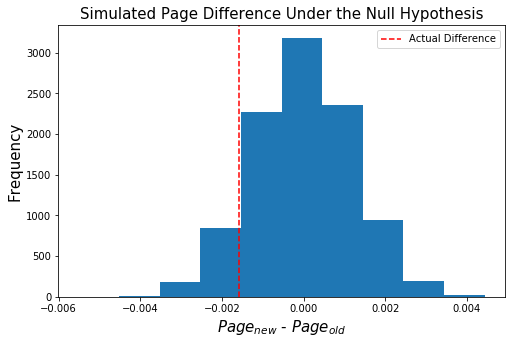

In [27]:
plt.figure(figsize=(8,5))
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
plt.hist(p_diffs)
plt.title("Simulated Page Difference Under the Null Hypothesis", fontsize=15)
plt.xlabel("$Page_{new}$ - $Page_{old}$", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.axvline(x=obs_diff, color='red', linestyle='dashed', label='Actual Difference')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(np.array(p_diffs) > obs_diff).mean()

0.9031

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<h3>Answer:</h3>
<ul>
    - What was just computed in part j is in fact called the <b>p-value</b>. It is defined as the probability of observing a statistic (or more extremly in favor of the Alternative) if the Null Hypothesis is true.
<br><br>
- Thus, the less the p-value, the more is it acceptable for us to <b>reject the Null Hypothesis</b>. Usually, the p-value is compared to a certain threshold for commiting <b>type I Errors ($\alpha$).</b>
<br><br>
- In our study here, we put ($\alpha$) as 5%. It is obvious that our calculated p-value (90.31%) is much greater than that. Thus, we <b>fail to reject the Null Hypothesis.</b> That is, we believe it's probably better to use the old page rather than the new one based on our statistical analysis.</ul>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

# Number of Conversion Trials in Each Page
trials_old = df2.query('group == "control"').converted.sum()
trials_new = df2.query('group == "treatment"').converted.sum()

# Number of Conversions (Successes) in each page were already calculated above
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([trials_new, trials_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<h3>Answer:</h3>
<ul>
- We can clearly see that the p-value is the same as obtained above; showing that we failed to reject the Null Hypothesis.<br><br>
- The z-score (also called the 'Standard score') is defined as the number of standard deviations by which the value of a raw score is above or below the mean value of what is being observed or measured.$^{[1]}$<br><br> 

<div style="font-size:25px"><center>$Z=\frac{x-\mu}{\sigma}$</center></div>
Where:
<ul>
$Z = standard$ $score$<br>
$x = observed$ $value$<br>
$\mu = mean$ $of$ $the$ $sample$<br>
$\sigma = standard$ $deviation$ $of$ $the$ $sample$
</ul><br>
- Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores.
<br><br>
- The <b>Critical Value of z</b> is term linked to the area under the standard normal model. Critical values can tell you what probability any particular variable will have.</b>
<br><br>
- As such, we are interested in comparing our calculated z-value with the critical value at a 95% confidence interval. After that, we can determine whether we reject the Null or not.</ul>

In [31]:
from scipy.stats import norm
norm.ppf(0.95)

1.6448536269514722

We can already see that the z-value obtained is less than the desired critical value for a 95% confidence interval. Thus, we indeed <b>fail to reject the Null Hypothesis</b>; agreeing with what we had already concluded in the previous parts (j & k).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression** (Binary Output)

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df.group)['treatment']
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
import statsmodels.api as sm
logit = sm.Logit(df2.converted, df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-19 04:14 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<h3>Answer:</h3><br>
<center><b>Null Hypothesis: No</b> relationship exists between "ab_page" & "converted"</center>
<center><b>Alternative Hypothesis:</b> There <b>is</b> a relationship between "ab_page" & "converted"</center><br>
Which can be written as:
<center>$H_0:$ $converted=1$ <b>if</b> $ab$_$page = 0$</center>
<center>$H_1:$ $converted=1$ <b>if</b> $ab$_$page = 1$</center>
<br><br>
- Of course, this is a fundamentally different hypothesis than before where we are now interested in the behaviour of individuals rather than the population as a whole.<br><br>
- Since the <b>p-value is 0.1899</b> (less than 0.05). Then, we fail to reject the null hypothesis. That is, we believe there is a relation between <b><code>ab_page</code></b> & <b><code>converted</code></b>.
<br><br>
- However, to actually interpret p-values of a logistic regression we first need to take their natural logarithm.

In [35]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

- Now, we may understand the calculated p-value by comparing them to the <b>basline</b> as follows: if a person uses the new page, it is 0.985 times more likely they will make a conversion than if they used the old page; or in other words, if a person uses the old page he is <b>1.0152 times more likely</b> to make a conversion (Where $\frac{1}{0.985}\approx1.0152$).<br><br>
- Of course this shows that, <b>statistically</b> speaking, we should indeed choose to use the old page instead. Practically however, we may or may not choose to use the new page as there isn't that much of a difference in probability.<br>
Taking such a decision would probably be based upon other external factors (like: Fees, Change Aversion, Novelty Effect, Hawthorne Effect, etc.)

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<h3>Answer:</h3>
    - Based on the data already collected, there doesn't seem to be any sort of impact due to the new page. This may simply be due to there actually being no correlation or perhaps not enough data were collected. Perhaps we may need to study new certain features like:
<ul>
    Time Spent on Page, Age, Nationality, Gender, Time of Day, Device Used to Access Page, etc.
</ul>
<br>
- It would be a good idea to take all these different features into consideration and fit them into our model, but we need to be careful of making a very complex model that is hard to interpret or having features are related to each other causing <b>Multicollinearity</b>.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
# Loading the data
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Finding out the 3 dummy variables
df_c.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [38]:
# Merging the two tables using user_id column into DataFrame3
df3 = df2.set_index('user_id').join(df_c.set_index('user_id'))

# Adding dummy variables columns
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3.country)

# Dropping the extra dummy variable which will be the 'baseline'
df3 = df3.drop('CA', axis=1)

df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [39]:
# intercept column already added

# Creating the logistic reggresion model
logit2 = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'US', 'UK']])
result2 = logit.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-19 04:14 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [40]:
# Exponentiating explanatory variables and reciprocals to interpret the results
np.exp(result2.params), 1/np.exp(result2.params)

(intercept    0.136863
 ab_page      0.985123
 dtype: float64,
 intercept    7.306593
 ab_page      1.015102
 dtype: float64)

<h2>Logistic Model Countries Interpretations:</h2>
<ul>
    1 - if a person is from CA, they are 1.051944 more likely to make a conversion than if they were from UK, holding all other variables constant.<br>
    2 - if a person is from CA, they are 1.041599 more likely to make a conversion than if they were from US, holding all other variables constant.<br>
</ul>
Based on these interpretations and the p-values that are considerably larger than 0.05, we conclude that the country of origin of a user does <b>NOT</b> have much of an impact on the probability of their conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# Creating necessary additional columns for interaction variables
df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [42]:
# Logistic regression for the intereaction variables
logit3 = sm.Logit(df3.converted, df3[['intercept', 'UK', 'US', 'ab_page', 'US_ab_page', 'UK_ab_page']])
result3 = logit3.fit()
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-09-19 04:14 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

In [43]:
# Exponentiating explanatory variables and reciprocals to interpret the results
np.exp(result3.params), 1/np.exp(result3.params)

(intercept     0.134794
 UK            1.011854
 US            1.017682
 ab_page       0.934776
 US_ab_page    1.048001
 UK_ab_page    1.081428
 dtype: float64,
 intercept     7.418713
 UK            0.988285
 US            0.982625
 ab_page       1.069775
 US_ab_page    0.954198
 UK_ab_page    0.924703
 dtype: float64)

- We can see that the p-value for `UK`, `US`, has dramatically increased due to being related to `UK_ab_page`, `US_ab_page` respectively.<br><br>
- The p-values for all features (even the interaction variables) are much higher than 0.05 showing that they have no considerable significance effect on the conversion rate.<br><br>
- This shows that the country dataset is <b>NOT</b> a good fit to predit conversion rate.

<a id='conclusion'></a>
### Conclusion
- This whole study and analysis of the provided dataset was an attempt to determine whether the e-commerce website should launch the new page or stick with the old one.<br><br>
- Upon analyzing using various methods (Descriptive Statistics, Hypothesis Testing, Logistic Regression) it was found that the difference between the conversion rate for the new page and that of the old page is somewhat negligible.<br><br>
- In fact, the old page had a higher conversion rate!<br><br>
- All of the aforementioned results would lead me to advise against the launch of this new page as there seems to be no actual use for such a hassle. <br><br>
- However, it would still be wise to keep gathering more data as there could be many different reasons for such results other than the new page simply being inferior to the old one.

<a id='resources'></a>
### Resources
1. https://www.statisticshowto.com/probability-and-statistics/z-score/